In [1]:
import numpy as np
import torch

import torch.nn.functional as F

from sklearn.neighbors import NearestNeighbors
from PIL import Image
from skimage.color import rgb2lab, lab2rgb

In [2]:
prior_probs = np.load('util/prior_probs.npy')

pts_in_hull = np.load('util/pts_in_hull.npy')

print(pts_in_hull.shape)
print(pts_in_hull)
print(prior_probs)

(313, 2)
[[ -90   50]
 [ -90   60]
 [ -90   70]
 [ -90   80]
 [ -90   90]
 [ -80   20]
 [ -80   30]
 [ -80   40]
 [ -80   50]
 [ -80   60]
 [ -80   70]
 [ -80   80]
 [ -80   90]
 [ -70    0]
 [ -70   10]
 [ -70   20]
 [ -70   30]
 [ -70   40]
 [ -70   50]
 [ -70   60]
 [ -70   70]
 [ -70   80]
 [ -70   90]
 [ -60  -20]
 [ -60  -10]
 [ -60    0]
 [ -60   10]
 [ -60   20]
 [ -60   30]
 [ -60   40]
 [ -60   50]
 [ -60   60]
 [ -60   70]
 [ -60   80]
 [ -60   90]
 [ -50  -30]
 [ -50  -20]
 [ -50  -10]
 [ -50    0]
 [ -50   10]
 [ -50   20]
 [ -50   30]
 [ -50   40]
 [ -50   50]
 [ -50   60]
 [ -50   70]
 [ -50   80]
 [ -50   90]
 [ -50  100]
 [ -40  -40]
 [ -40  -30]
 [ -40  -20]
 [ -40  -10]
 [ -40    0]
 [ -40   10]
 [ -40   20]
 [ -40   30]
 [ -40   40]
 [ -40   50]
 [ -40   60]
 [ -40   70]
 [ -40   80]
 [ -40   90]
 [ -40  100]
 [ -30  -50]
 [ -30  -40]
 [ -30  -30]
 [ -30  -20]
 [ -30  -10]
 [ -30    0]
 [ -30   10]
 [ -30   20]
 [ -30   30]
 [ -30   40]
 [ -30   50]
 [ -30   60]
 [ 

In [3]:
def compute_rebalance_weights(p, Q=313, lam=0.5):
    """
    p: numpy array of shape (313,), empirical distribution over color bins
    returns: weight array of shape (313,)
    """
    mixed = (1 - lam) * p + lam / Q
    w = 1 / mixed
    w *= 1 / np.sum(w * p)  # normalize to expected value 1
    return w


rebalance_weights = compute_rebalance_weights(prior_probs)  # shape: (313,)
print(np.sum(rebalance_weights*prior_probs))  # should be close to 1.0


rebalance_weights = torch.tensor(rebalance_weights, dtype=torch.float32)


0.9999999999999998


In [4]:
print(rebalance_weights)
print(rebalance_weights.shape)

tensor([6.1748, 6.1746, 6.1738, 6.1698, 6.1730, 6.1748, 6.1744, 6.1734, 6.1711,
        6.1691, 6.1655, 6.1640, 6.1724, 6.1747, 6.1737, 6.1705, 6.1647, 6.1580,
        6.1491, 6.1398, 6.1440, 6.1610, 6.1726, 6.1741, 6.1712, 6.1641, 6.1480,
        6.1287, 6.1085, 6.0831, 6.0454, 6.0383, 6.0929, 6.1432, 6.1690, 6.1734,
        6.1433, 6.0912, 6.0634, 6.0108, 5.9536, 5.8680, 5.7048, 5.5833, 5.7096,
        5.9389, 6.0968, 6.1609, 6.1745, 6.1732, 6.1331, 5.9648, 5.7832, 5.7002,
        5.5932, 5.3308, 4.7818, 4.3173, 4.4645, 5.0848, 5.6997, 6.0275, 6.1458,
        6.1735, 6.1734, 6.1249, 5.8573, 5.4481, 5.0725, 4.8059, 4.3274, 3.3717,
        2.6373, 2.6962, 3.4877, 4.6399, 5.5413, 5.9573, 6.0998, 6.1642, 6.1304,
        5.7790, 5.0648, 4.2936, 3.4839, 2.6950, 2.0020, 1.5563, 1.5575, 2.1422,
        3.3261, 4.6373, 5.4502, 5.7998, 5.9648, 6.1398, 6.1499, 5.8137, 4.6767,
        3.1737, 1.9670, 0.8827, 0.3772, 0.4866, 0.7975, 1.3020, 2.3020, 3.6430,
        4.7003, 5.2899, 5.6466, 5.9634, 

In [5]:
inverse_weights = compute_rebalance_weights(prior_probs, lam=0)  # shape: (313,)
inverse_weights = torch.tensor(inverse_weights, dtype=torch.float32)

print(inverse_weights)

tensor([6.5384e+04, 2.3065e+04, 5.5411e+03, 1.2105e+03, 3.3619e+03, 8.9570e+04,
        1.2593e+04, 4.2455e+03, 1.6286e+03, 1.0597e+03, 6.5383e+02, 5.6642e+02,
        2.4684e+03, 3.4109e+04, 5.0282e+03, 1.4222e+03, 6.0791e+02, 3.6446e+02,
        2.3826e+02, 1.7479e+02, 1.9878e+02, 4.4238e+02, 2.6816e+03, 7.6271e+03,
        1.6923e+03, 5.7435e+02, 2.2914e+02, 1.3268e+02, 9.1965e+01, 6.6245e+01,
        4.6677e+01, 4.4204e+01, 7.4365e+01, 1.9380e+02, 1.0559e+03, 4.1288e+03,
        1.9426e+02, 7.2819e+01, 5.4396e+01, 3.6625e+01, 2.6900e+01, 1.9121e+01,
        1.2136e+01, 9.4379e+00, 1.2272e+01, 2.5162e+01, 7.8122e+01, 4.4200e+02,
        1.5999e+04, 3.5813e+03, 1.4677e+02, 2.8396e+01, 1.4765e+01, 1.2009e+01,
        9.6152e+00, 6.3154e+00, 3.4326e+00, 2.3242e+00, 2.6102e+00, 4.6645e+00,
        1.1996e+01, 4.0894e+01, 2.1123e+02, 4.6175e+03, 4.0728e+03, 1.2267e+02,
        1.8443e+01, 7.4965e+00, 4.6013e+00, 3.5105e+00, 2.3424e+00, 1.2028e+00,
        7.4551e-01, 7.7507e-01, 1.2979e+

In [6]:
# print(rebalance_weights - inverse_weights)

In [7]:
def soft_encode_ab(ab_image, pts_in_hull, sigma=5):
    """
    ab_image: torch tensor of shape (2, H, W)
    pts_in_hull: numpy array of shape (313, 2)
    returns: soft encoding of shape (H, W, 313)
    """
    C, H, W = ab_image.shape
    assert C == 2, "Expected input with 2 channels (a and b)"

    # Convert to (H, W, 2)
    ab_image = ab_image.permute(1, 2, 0)
    ab_flat = ab_image.reshape(-1, 2).cpu().numpy()
    
    # Nearest neighbors search
    nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(pts_in_hull)
    dists, inds = nbrs.kneighbors(ab_flat)
    print(dists, inds)

    # Gaussian kernel
    dists = np.clip(dists, 0, 30)
    weights = np.exp(-dists**2 / (2 * sigma**2))

    # print(weights)
    
    weights_sum = np.sum(weights, axis=1, keepdims=True)
    weights_sum[weights_sum == 0] = 1e-8  # prevent div by zero

    # print(weights_sum)
    
    weights /= weights_sum #normalize

    # Soft encoding
    soft_enc = np.zeros((ab_flat.shape[0], 313), dtype=np.float32)
    for i in range(5):
        soft_enc[np.arange(ab_flat.shape[0]), inds[:, i]] = weights[:, i]
    print(soft_enc.shape)

    # Reshape back to (H, W, 313)
    return torch.from_numpy(soft_enc).reshape(H, W, 313)



In [8]:
path = r'test_img/000000000139.jpg'

img = Image.open(path).convert("RGB")
img = np.array(img)

img_lab = rgb2lab(img).astype("float32")

print(np.max(img))
print(np.min(img))

239
0


In [9]:
print(np.max(img_lab[:, :, 0] ))
print(np.min(img_lab[:, :, 0] ))

89.55192
0.6781091


In [10]:
print(np.max(img_lab[:, :, 1] ))
print(np.min(img_lab[:, :, 1] ))

67.09106
-30.223099


In [11]:
print(np.max(img_lab[:, :, 2] ))
print(np.min(img_lab[:, :, 2] ))

62.69639
-21.97305


In [12]:
path = r'test_img/000000001000.jpg'  # Use raw string to handle backslashes

height = 224
width = 224

img = Image.open(path).convert("RGB")
img = img.resize((height, width), Image.BICUBIC)
img = np.array(img)  # Convert PIL to NumPy (Albumentations requires NumPy)


# If img is in (C, H, W) format, convert to (H, W, C)
if img.shape[0] == 3:
    img = np.transpose(img, (1, 2, 0))  # Convert (C, H, W) → (H, W, C)

# Convert RGB → LAB
img_lab = rgb2lab(img).astype("float32")  # (H, W, 3)

# Extract L and ab channels
L = img_lab[:, :, 0] 
ab = img_lab[:, :, 1:]

# Convert to PyTorch tensors
L = torch.tensor(L, dtype=torch.float32).unsqueeze(0)  # (1, H, W)
ab = torch.tensor(ab, dtype=torch.float32).permute(2, 0, 1)  # (2, H, W)

# ab: [2, H, W] ground truth ab channels
ab_downsampled = F.interpolate(
    ab.unsqueeze(0),  # Add batch dim -> shape: [1, 2, H, W]
    scale_factor=0.25,
    mode='bilinear',
    align_corners=False
).squeeze(0)  # Remove batch dim -> back to [2, H/4, W/4]  

# print(ab_downsampled)  # (2, H/4, W/4)

# Soft encode ab (call external function)
soft_encoded = soft_encode_ab(ab_image = ab_downsampled, pts_in_hull = pts_in_hull)  # (H/4, W/4, 313), NumPy
soft_encoded = soft_encoded.float().permute(2, 0, 1)  # To Tensor (313, H/4, W/4)

print(soft_encoded.shape) 

print(torch.min(soft_encoded))

print(torch.sum(soft_encoded, dim=0))

[[ 2.58317488  7.48114951  9.83708474 10.79709909 12.08565438]
 [ 1.18852688  9.02919276  9.40162309 10.69741444 11.01357664]
 [ 2.84120081  7.25994113  9.76121839 10.99379187 11.82859703]
 ...
 [ 1.73430834  8.33873524  9.69101054 10.58772712 11.68251452]
 [ 0.97965549  9.10032518  9.67286435 10.40937774 10.91345643]
 [ 4.79914006  6.00917999  9.07310157  9.76727551 12.79618375]] [[105 123 106 104 124]
 [122 104 121 123 141]
 [123 122 105 142 104]
 ...
 [101  84 100 102 119]
 [101 119 100 102  84]
 [102 101 120 119  85]]
(3136, 313)
torch.Size([313, 56, 56])
tensor(0.)
tensor([[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        ...,
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]])


In [13]:
from collections import OrderedDict


from model_build import CNN

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

model = CNN.colorization()

state_dict = torch.load("model/model_OG_init.pth")

new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k.replace("module.", "")  # remove 'module.' prefix
    new_state_dict[name] = v

model.load_state_dict(new_state_dict)
model = model.eval().to(device)

with torch.no_grad():
        # Encode the input image
        with torch.cuda.amp.autocast():
            outputs = model(L.unsqueeze(0).to(device))

print(outputs.shape)  # (1, 313, H/4, W/4)
print(outputs) 

C:\Users\MY LAPTOP\AppData\Local\Temp\ipykernel_13948\3694084662.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("model/model_OG_init.pth")
C:\U

torch.Size([1, 313, 56, 56])
tensor([[[[-1.2041, -1.8740, -2.0215,  ..., -1.7324, -1.7539, -1.1914],
          [-1.8838, -2.9297, -3.1816,  ..., -2.5117, -2.5801, -1.7578],
          [-2.0430, -3.1777, -3.4746,  ..., -2.4512, -2.5723, -1.7744],
          ...,
          [-2.4922, -4.1484, -4.8594,  ..., -2.2871, -2.4414, -1.6787],
          [-2.0918, -3.4219, -3.9473,  ..., -2.3125, -2.4102, -1.6416],
          [-1.2568, -2.0176, -2.2910,  ..., -1.5859, -1.6182, -1.0869]],

         [[-1.2041, -1.8730, -2.0215,  ..., -1.7324, -1.7549, -1.1924],
          [-1.8828, -2.9277, -3.1797,  ..., -2.5117, -2.5820, -1.7588],
          [-2.0430, -3.1758, -3.4727,  ..., -2.4531, -2.5723, -1.7754],
          ...,
          [-2.4902, -4.1445, -4.8555,  ..., -2.2852, -2.4414, -1.6787],
          [-2.0918, -3.4199, -3.9453,  ..., -2.3105, -2.4102, -1.6416],
          [-1.2559, -2.0176, -2.2910,  ..., -1.5850, -1.6182, -1.0869]],

         [[-1.1768, -1.8281, -1.9658,  ..., -1.7246, -1.7441, -1.1836],
 

In [14]:
from model_build import VGG_pre
import torch.nn as nn
 

model2 = VGG_pre.colorization()

state_dict2 = torch.load("model/model_VVG_pre.pth")

new_state_dict2 = OrderedDict()
for k, v in state_dict2.items():
    name = k.replace("module.", "")  # remove 'module.' prefix
    new_state_dict2[name] = v

model2.load_state_dict(new_state_dict2)
model2 = model2.eval().to(device)

with torch.no_grad():
        # Encode the input image
        with torch.cuda.amp.autocast():
            outputs2 = model2(L.unsqueeze(0).to(device))

print(outputs2.shape)  # (1, 313, H/4, W/4)
print(outputs2) 

C:\Users\MY LAPTOP\AppData\Local\Temp\ipykernel_13948\2413649161.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict2 = torch.load("model/model_VVG_pre.pth")


torch.Size([1, 313, 56, 56])
tensor([[[[-2.0371, -3.1250, -3.3789,  ..., -3.5273, -3.2734, -2.1387],
          [-3.1133, -4.6836, -4.9336,  ..., -5.2383, -4.9297, -3.2402],
          [-3.3848, -4.9805, -5.0938,  ..., -5.4961, -5.2812, -3.5234],
          ...,
          [-2.3496, -3.3535, -3.2637,  ..., -3.8340, -4.0312, -2.8398],
          [-2.3125, -3.3906, -3.4102,  ..., -4.0430, -4.0469, -2.7520],
          [-1.5371, -2.3066, -2.3867,  ..., -2.8262, -2.7402, -1.8232]],

         [[-2.0391, -3.1211, -3.3730,  ..., -3.5039, -3.2520, -2.1191],
          [-3.1113, -4.6719, -4.9258,  ..., -5.1992, -4.8906, -3.2109],
          [-3.3828, -4.9727, -5.0820,  ..., -5.4492, -5.2383, -3.4883],
          ...,
          [-2.3438, -3.3418, -3.2520,  ..., -3.8223, -4.0195, -2.8281],
          [-2.3066, -3.3809, -3.4004,  ..., -4.0352, -4.0352, -2.7441],
          [-1.5303, -2.3008, -2.3809,  ..., -2.8203, -2.7344, -1.8213]],

         [[-2.0117, -3.0859, -3.3340,  ..., -3.4824, -3.2324, -2.1113],
 

C:\Users\MY LAPTOP\AppData\Local\Temp\ipykernel_13948\2413649161.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


In [15]:
soft_encoded = soft_encoded.unsqueeze(0).to(device)

In [16]:
def get_pixel_weight(soft_label, weights):
    """
    soft_label: (B, 313, H, W) soft encoding tensor
    weights: (313,) numpy array or tensor
    returns: (B, H, W) tensor of pixel weights
    """
    if soft_label.dim() != 4 or soft_label.shape[1] != 313:
        raise ValueError(f"Expected shape (B, 313, H, W), got {soft_label.shape}")

    # Move channel to last dimension: (B, H, W, 313)
    soft_label = soft_label.permute(0, 2, 3, 1)

    max_idx = torch.argmax(soft_label, dim=3)  # (B, H, W)

    if isinstance(weights, np.ndarray):
        weight_tensor = torch.from_numpy(weights).to(soft_label.device)
    else:
        weight_tensor = weights.to(soft_label.device)

    return weight_tensor[max_idx]  # (B, H, W)

In [17]:
pixel_weights = get_pixel_weight(soft_encoded, rebalance_weights)

print(pixel_weights.shape)  # (1, H/4, W/4)
print(pixel_weights)  # (1, H/4, W/4)

print(torch.min(pixel_weights))  # (1, H/4, W/4)
print(torch.max(pixel_weights))  # (1, H/4, W/4)

torch.Size([1, 56, 56])
tensor([[[1.3020, 0.4413, 0.9991,  ..., 0.0965, 0.1769, 0.1769],
         [0.9991, 0.4413, 0.4413,  ..., 0.1769, 0.1769, 0.1769],
         [0.4413, 0.4413, 1.3020,  ..., 0.1769, 0.1769, 0.0965],
         ...,
         [0.0965, 0.0965, 0.8827,  ..., 0.8827, 0.8827, 0.3772],
         [0.0965, 0.8827, 0.8827,  ..., 0.8827, 0.8827, 0.3772],
         [0.2927, 0.8827, 1.9670,  ..., 0.8827, 0.8827, 0.3772]]],
       device='cuda:0')
tensor(0.0965, device='cuda:0')
tensor(6.0013, device='cuda:0')


In [18]:
def cross_entropy_with_soft_targets(pred_logits, soft_targets, pixel_weights=None):
    """
    pred_logits: (B, 313, H, W) — model outputs (logits)
    soft_targets: (B, 313, H, W) — soft-encoded targets
    pixel_weights: (B, H, W) — optional pixel-wise weighting
    """
    log_preds = F.log_softmax(pred_logits, dim=1)  # (B, 313, H, W)
    log_preds = torch.clamp(log_preds, min=-100)  # prevent -inf

    # Element-wise product and sum over channels
    loss = -(soft_targets * log_preds).sum(dim=1)  # (B, H, W)

    if pixel_weights is not None:
        loss = loss * pixel_weights  # (B, H, W)

    return loss.mean()

In [19]:
loss = cross_entropy_with_soft_targets(outputs2,soft_encoded , pixel_weights=pixel_weights)

print(loss)

tensor(5.0095, device='cuda:0')


In [20]:
def soft_to_ab(soft_map, color_bins):
    """
    soft_map: (B, 313, H, W) — soft probability over quantized bins
    color_bins: (313, 2) — ab values for each quantized bin
    Returns:
        ab_map: (B, 2, H, W)
    """
    B, _, H, W = soft_map.shape
    color_bins = torch.tensor(color_bins, dtype=soft_map.dtype, device=soft_map.device)  # (313, 2)

    # reshape softmap to (B, H, W, 313), then do a weighted sum along 313
    soft_map = soft_map.permute(0, 2, 3, 1)  # (B, H, W, 313)
    ab_map = torch.matmul(soft_map, color_bins)  # (B, H, W, 2)
    ab_map = ab_map.permute(0, 3, 1, 2)  # (B, 2, H, W)
    return ab_map


In [21]:
def compute_class_balanced_auc(pred_ab, true_ab, inverse_weights, pts_in_hull, max_thresh=150):
    """
    pred_ab, true_ab: (B, 2, H, W)
    color_freq: (313,) normalized class frequency
    """
    # Compute L2 distance per pixel
    l2_error = torch.linalg.norm(pred_ab - true_ab, dim=1)   # (B, H, W)
    error_flat = l2_error.flatten().cpu().numpy()

    # Inverse class weights
    weight = inverse_weights

    # Get the class for each pixel based on true_ab (use clustering or quantization)
    true_ab_exp = true_ab.permute(0, 2, 3, 1).reshape(-1, 2).cpu().numpy()
    
    # Compute L2 distance to cluster centers
    diff = true_ab_exp[:, None, :] - pts_in_hull[None, :, :]  # (47040, 313, 2)
    dist = np.linalg.norm(diff, axis=2)  # (47040, 313)

    bin_ids = np.argmin(dist, axis=1)  # Find the closest bin for each pixel

    # Use the class ids (bin_ids) to get the corresponding weight
    weighted_error = weight[bin_ids]
    weighted_error = weighted_error.cpu().numpy() 
    total_weight = weighted_error.sum() + 1e-6  # avoid divide-by-zero

    # Compute the CDF: cumulative distribution of errors weighted by class importance
    thresholds = np.arange(0, max_thresh + 1)
    cdf = []
    
    for t in thresholds:
        
        # Calculate cumulative weighted sum for pixels where error < threshold t
        cdf_value = weighted_error[error_flat < t].sum()
        cdf.append(cdf_value/ total_weight)

    # Normalize the CDF and compute AUC
    cdf = np.array(cdf)
    auc = np.trapz(cdf, thresholds) / max_thresh

    return auc, thresholds, cdf

In [22]:
pred_ab = torch.softmax(outputs2, dim=1)
print(torch.sum(pred_ab, dim=1))

pred_ab = soft_to_ab(pred_ab, pts_in_hull)      # pred_soft: (B, 313, H, W)
true_ab = soft_to_ab(soft_encoded, pts_in_hull)

print(pred_ab.shape)  # (1, 2, H/4, W/4)
print(true_ab.shape)  # (1, 2, H/4, W/4)
print(pred_ab)  # (1, 2, H/4, W/4)
print(true_ab)  # (1, 2, H/4, W/4)
print(torch.min(true_ab))  

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]], device='cuda:0',
       dtype=torch.float16)
torch.Size([1, 2, 56, 56])
torch.Size([1, 2, 56, 56])
tensor([[[[ -0.4636,  -5.3164,  -6.9727,  ...,   0.6104,   1.3125,   4.2148],
          [ -5.4727,  -8.2578,  -9.4844,  ...,  -1.3369,  -0.8721,   1.4131],
          [ -7.3008,  -9.6172, -10.6094,  ...,  -1.5342,  -1.1934,   0.7910],
          ...,
          [  7.9805,   7.7578,  10.3359,  ...,   5.8711,   5.7773,   7.1406],
          [  9.3828,   9.7188,  12.2188,  ...,   5.1797,   5.2422,   7.0977],
          [ 10.4766,  10.7891,  12.5547,  ...,   6.1680,   6.6055,   9.4766]],

         [[ 15.0156,  17.0469,  18.6875,  ...,   2.9746,   3.0625,   4.1602],
          [ 17.3125,  18.7812,  20.4219,  ...,   2.8535,   2.7598,   3.3281]

In [23]:
val_auc, thresholds, cdf_vals = compute_class_balanced_auc(
        pred_ab, true_ab, inverse_weights, pts_in_hull
    )

print(val_auc)  # AUC value

0.7379360510855137


C:\Users\MY LAPTOP\AppData\Local\Temp\ipykernel_13948\2383665126.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(cdf, thresholds) / max_thresh


In [26]:
from util import util

#Upsample logits to match 224x224
logits_upsampled = F.interpolate(outputs, scale_factor=4, mode='bilinear')  # (1, 313, 224, 224)

# Softmax along the 313 classes
prob = torch.softmax(logits_upsampled[0].permute(1, 2, 0), dim=-1).cpu().numpy()  # (224, 224, 313)
print(prob)

pts_in_hull = util.load_pts_in_hull()  # Load pts_in_hull from the file
ab = util.annealed_mean(prob, pts_in_hull)  # (1, 2, 224, 224)
print(ab.max(), ab.min())  # Check the range of ab values

L_np = L[0, 0].cpu().numpy()  # shape: (224, 224)
lab = np.zeros((224, 224, 3))
lab[:, :, 0] = L_np
lab[:, :, 1:] = ab

rgb = lab2rgb(lab)
print(rgb.max(), rgb.min())  # Check the range of RGB values

[[[0.000775  0.000775  0.0007963 ... 0.0007744 0.0007744 0.0007744]
  [0.000775  0.000775  0.0007963 ... 0.0007744 0.0007744 0.0007744]
  [0.000675  0.000675  0.000696  ... 0.0006747 0.0006747 0.0006747]
  ...
  [0.0007777 0.000777  0.0007834 ... 0.0007777 0.0007777 0.0007777]
  [0.0008583 0.000858  0.000865  ... 0.0008583 0.0008583 0.0008583]
  [0.0008583 0.000858  0.000865  ... 0.0008583 0.0008583 0.0008583]]

 [[0.000775  0.000775  0.0007963 ... 0.0007744 0.0007744 0.0007744]
  [0.000775  0.000775  0.0007963 ... 0.0007744 0.0007744 0.0007744]
  [0.000675  0.000675  0.000696  ... 0.0006747 0.0006747 0.0006747]
  ...
  [0.0007777 0.000777  0.0007834 ... 0.0007777 0.0007777 0.0007777]
  [0.0008583 0.000858  0.000865  ... 0.0008583 0.0008583 0.0008583]
  [0.0008583 0.000858  0.000865  ... 0.0008583 0.0008583 0.0008583]]

 [[0.000674  0.000674  0.000694  ... 0.0006733 0.0006733 0.0006733]
  [0.000674  0.000674  0.000694  ... 0.0006733 0.0006733 0.0006733]
  [0.0005784 0.0005784 0.000597 

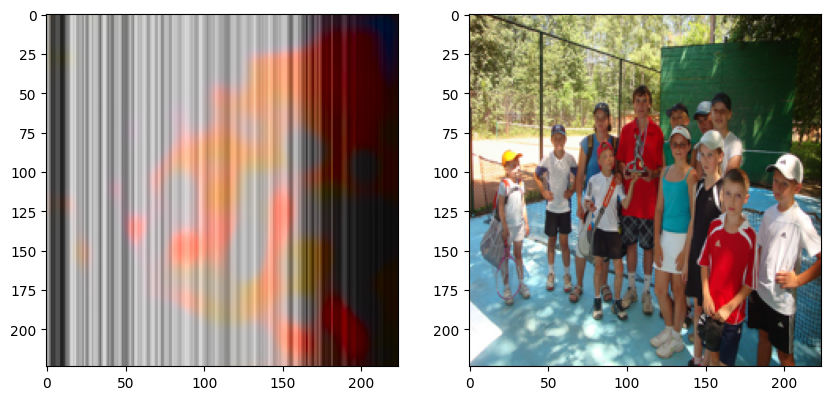

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(rgb)

plt.subplot(122)
plt.imshow(img)
plt.show()